## 자전거 수요 예측

## 1. Import & Data Check

In [124]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from scipy import stats 
from collections import Counter

import missingno as msno 
plt.style.use('seaborn') 

import warnings 
warnings.filterwarnings("ignore") 

mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스 폰트가 깨지는 것에 대한 대처
%matplotlib inline

In [125]:
os.listdir('./dataset/')

['bike-sharing-demand', 'house-prices-advanced-regression-techniques']

In [126]:
df_train = pd.read_csv('./dataset/bike-sharing-demand/train.csv', parse_dates = ["datetime"])
df_test = pd.read_csv('./dataset/bike-sharing-demand/test.csv', parse_dates = ["datetime"])

### 1) 데이터 확인

In [57]:
df_train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [58]:
df_train.info()

# 12개의 컬럼, datetime과 정수 실수 데이터로만 이루어져 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [127]:
df_train.shape, df_test.shape

((10886, 12), (6493, 9))

In [128]:
print(df_train.columns)
print(df_test.columns)

# target feature : count

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


### 2) 결측치 확인

In [114]:
# 결측치 확인해볼까

for col in df_train.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0])) 
    print(msperc)

# 모든 변수들에 결측치 하나도 없음

column:   datetime	 Percent of NaN value: 0.00%
column:     season	 Percent of NaN value: 0.00%
column:    holiday	 Percent of NaN value: 0.00%
column: workingday	 Percent of NaN value: 0.00%
column:    weather	 Percent of NaN value: 0.00%
column:       temp	 Percent of NaN value: 0.00%
column:      atemp	 Percent of NaN value: 0.00%
column:   humidity	 Percent of NaN value: 0.00%
column:  windspeed	 Percent of NaN value: 0.00%
column:     casual	 Percent of NaN value: 0.00%
column: registered	 Percent of NaN value: 0.00%
column:      count	 Percent of NaN value: 0.00%


<AxesSubplot:>

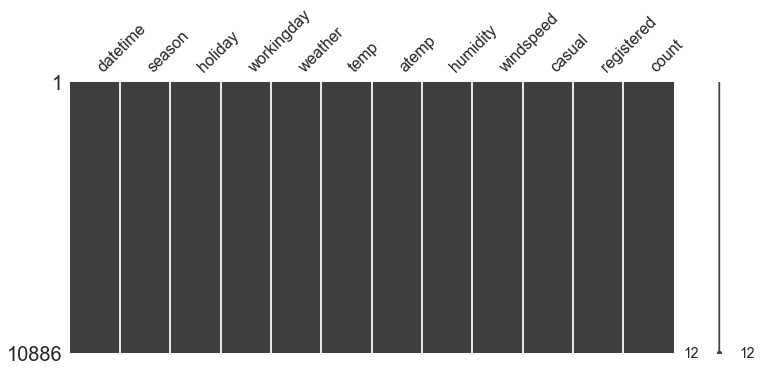

In [115]:
# 막대그래프 그려볼게ㅑ
msno.matrix(df_train, figsize=(12,5))

In [5]:
# 사전에 datetime 변경 안했을 때 꼭 해줘야 하는 코드
# train 과 test모두 변경해줄 것

# df_train['datetime'] = pd.to_datetime(df_train['datetime'])
# df_test['datetime'] = pd.to_datetime(df_test['datetime'])

### 3) 이상치 확인 - 수치형 데이터를 기준으로

In [129]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v> n)
    
    return multiple_outliers

# 수치형 변수들에 대해 이상치 판단!!!
Outlier_to_drop = detect_outliers(df_train, 2,["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"])

In [130]:
len(df_train.loc[Outlier_to_drop]) 
# 40개

40

In [131]:
df_train = df_train.drop(Outlier_to_drop, axis = 0).reset_index(drop=True)
df_train.shape

(10846, 12)

### 4) 비대칭성 확인

Skewness : 1.210923
Skewness : 1.200871


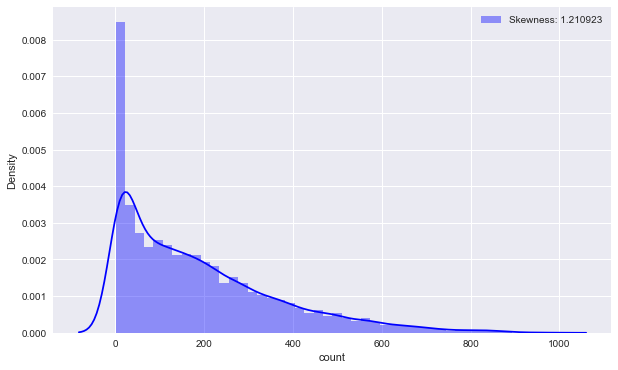

In [132]:
# 이번에는 타겟 변수의 비대칭성 확인

f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["count"], color = "b", label="Skewness: {:2f}".format(df_train["count"].skew()), ax=ax) 
g = g.legend(loc = "best")

print("Skewness : %f" % df_train['count'].skew())
print("Skewness : %f" % df_train['count'].kurt())

# 그래프에 치우침이 있으니 feature engineering 부분에서 조정해줄 것

In [133]:
df_train_num = df_train[["count", "temp", "atemp", "casual", "registered", "humidity", "windspeed"]] 
for col in df_train_num: 
    print('{:15}'.format(col), 'Skewness: {:05.2f}'.format(df_train[col].skew()) , ' ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt()) )

# engineering 에서 조정해주자

count           Skewness: 01.21   Kurtosis: 001.20
temp            Skewness: 00.01   Kurtosis: -00.91
atemp           Skewness: -0.10   Kurtosis: -00.85
casual          Skewness: 02.52   Kurtosis: 007.74
registered      Skewness: 01.51   Kurtosis: 002.61
humidity        Skewness: -0.09   Kurtosis: -00.76
windspeed       Skewness: 00.58   Kurtosis: 000.63


## 2. EDA

### 1) datetime 변수를 기준으로 기준별 자전거 수요량 확인

In [134]:
# 1. 기준별 자전거 수요량 확인하기 .
# datetime 의 연, 월, 일, 시, 분, 초로 나누어 자전거 수요량 확인

df_train['year'] = df_train['datetime'].dt.year
df_train['month'] = df_train['datetime'].dt.month
df_train['day'] = df_train['datetime'].dt.day
df_train['hour'] = df_train['datetime'].dt.hour
df_train['minute'] = df_train['datetime'].dt.minute
df_train['second'] = df_train['datetime'].dt.second
df_train['dayofweek'] = df_train['datetime'].dt.dayofweek

df_test['year'] = df_test['datetime'].dt.year
df_test['month'] = df_test['datetime'].dt.month
df_test['day'] = df_test['datetime'].dt.day
df_test['hour'] = df_test['datetime'].dt.hour
df_test['minute'] = df_test['datetime'].dt.minute
df_test['second'] = df_test['datetime'].dt.second
df_test['dayofweek'] = df_test['datetime'].dt.dayofweek

In [135]:
df_train.shape

(10846, 19)

#### 기준별 막대그래프

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental amount by dayofweek')]

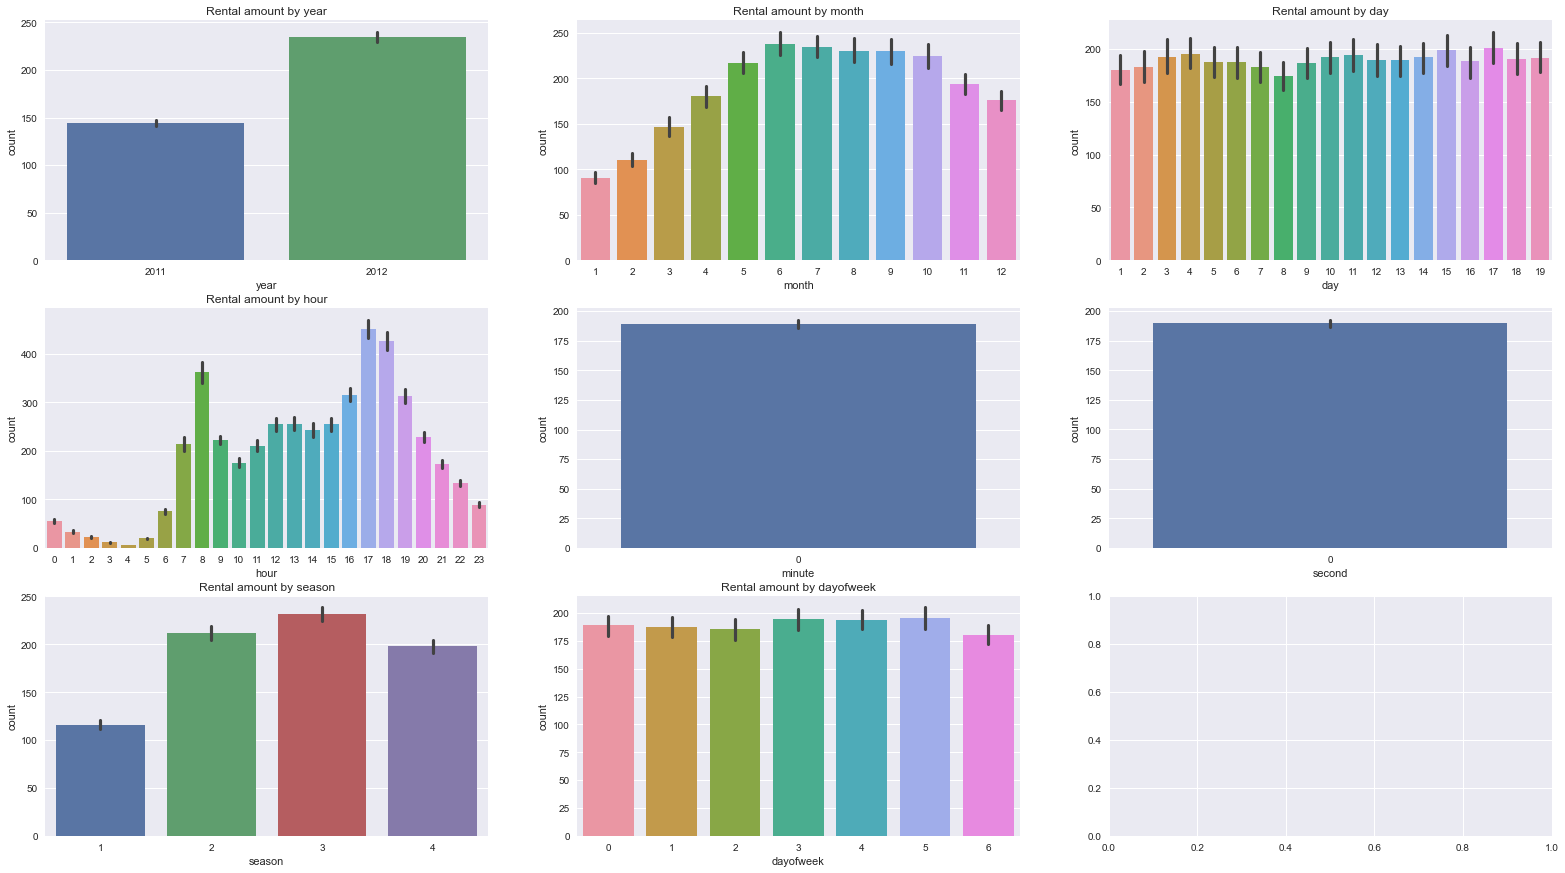

In [136]:
figure, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows = 3, ncols = 3) 
figure.set_size_inches(27,15) 
sns.barplot(data=df_train, x = "year", y = "count", ax = ax1) 
sns.barplot(data=df_train, x = "month", y = "count", ax = ax2) 
sns.barplot(data=df_train, x = "day", y = "count", ax = ax3) 
sns.barplot(data=df_train, x = "hour", y = "count", ax = ax4) 
sns.barplot(data=df_train, x = "minute", y = "count", ax = ax5) 
sns.barplot(data=df_train, x = "second", y = "count", ax = ax6) 
sns.barplot(data=df_train, x='season', y='count', ax = ax7)
sns.barplot(data=df_train, x='dayofweek', y='count', ax = ax8)

ax1.set(ylabel = "count", title = "Rental amount by year") 
ax2.set(ylabel = "count", title = "Rental amount by month") 
ax3.set(ylabel = "count", title = "Rental amount by day") 
ax4.set(ylabel = "count", title = "Rental amount by hour")
ax7.set(ylabel = "count", title = "Rental amount by season")
ax8.set(ylabel = "count", title = "Rental amount by dayofweek")

# 2011년도보다 12년도에 수요량이 증가
# 1,2,3월에는 자전거 잘 안타고, 6,7,8월인 여름에 많이 탐
# 오전8시나 오후 5-6시 출퇴근 시간

In [137]:
df_train['dayofweek'].value_counts()
# 0: 월요일~ 6: 일요일
# 토요일에 이용량이 제일 많고 금요일에 적음 근데 별로 차이 안남

5    1580
6    1578
0    1547
3    1546
2    1543
1    1533
4    1519
Name: dayofweek, dtype: int64

In [82]:
# 계절을 나누는 기준이 뭘까
df_train[df_train['season']==1].month.unique() # 1 겨울 : 1,2,3
df_train[df_train['season']==2].month.unique() # 2: 봄 : 4,5,6
# season도 차이가 존재하므로 예측 변수로 사용할 수 있겠다

array([4, 5, 6], dtype=int64)

#### 시간대별 꺽은선 그래프

<AxesSubplot:xlabel='hour', ylabel='count'>

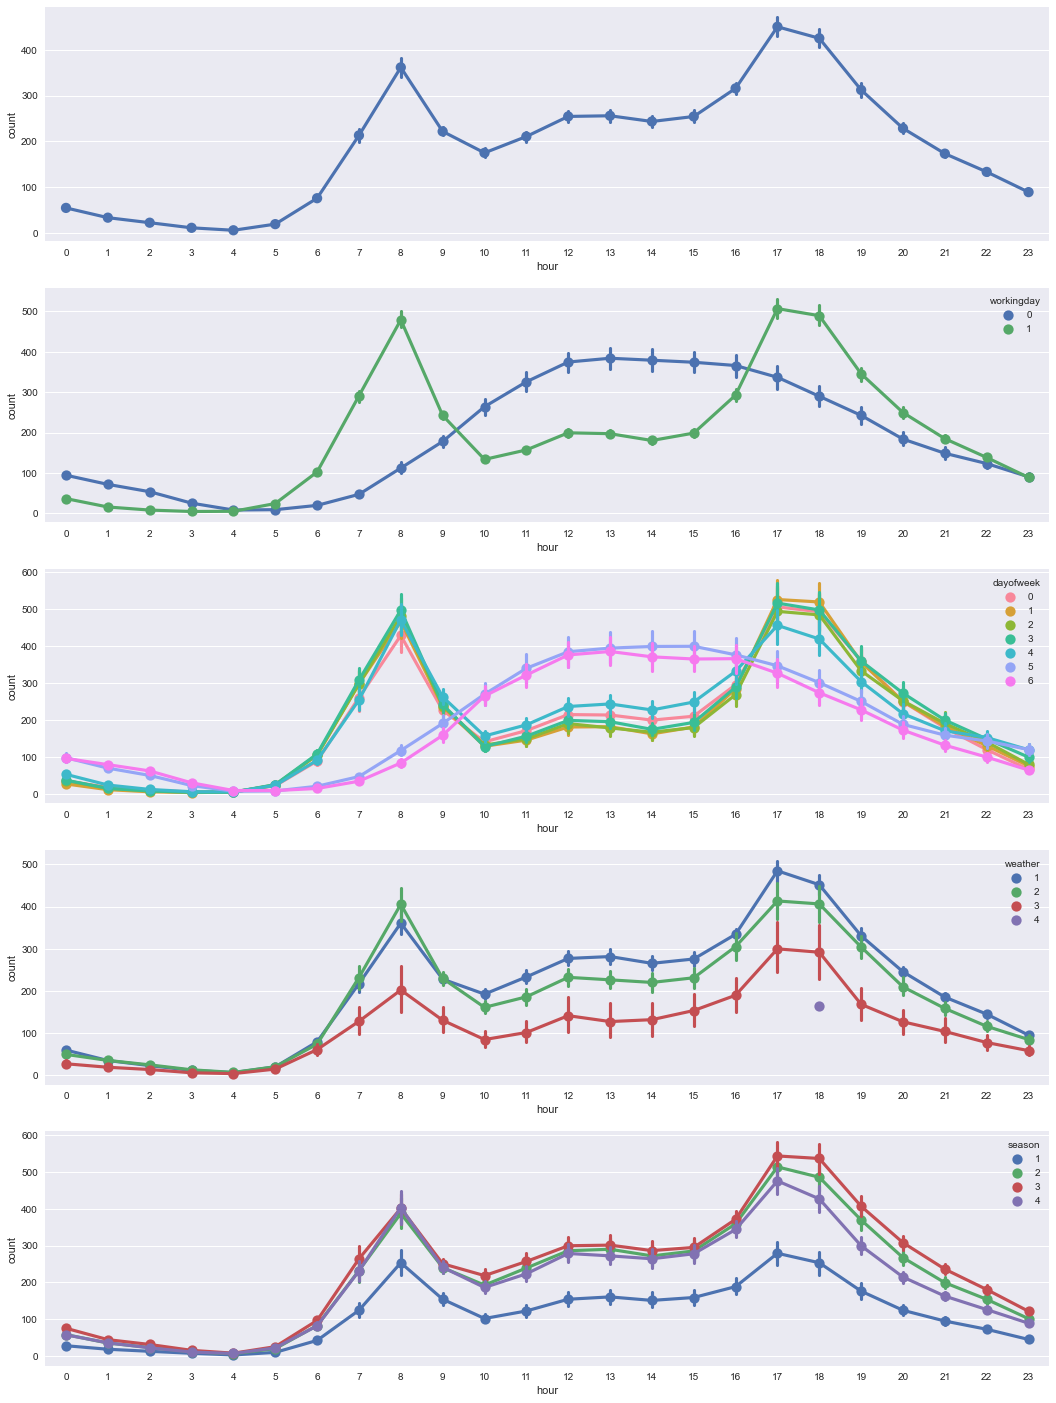

In [39]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5) 
fig.set_size_inches(18,25) 

sns.pointplot(data = df_train, x = "hour", y = "count", ax = ax1) 
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "workingday", ax = ax2) # 1: working 
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "dayofweek", ax = ax3) 
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "weather", ax = ax4) 
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "season", ax = ax5) # 시즌별 꺽은선 그래프

# 일하는 날과 일하지 않는 날의 차이가 드러남, workingday나 dayofweek에서
# 봄에 사용량이 제일 적음. 나머지는 비슷비슷

<AxesSubplot:xlabel='hour', ylabel='count'>

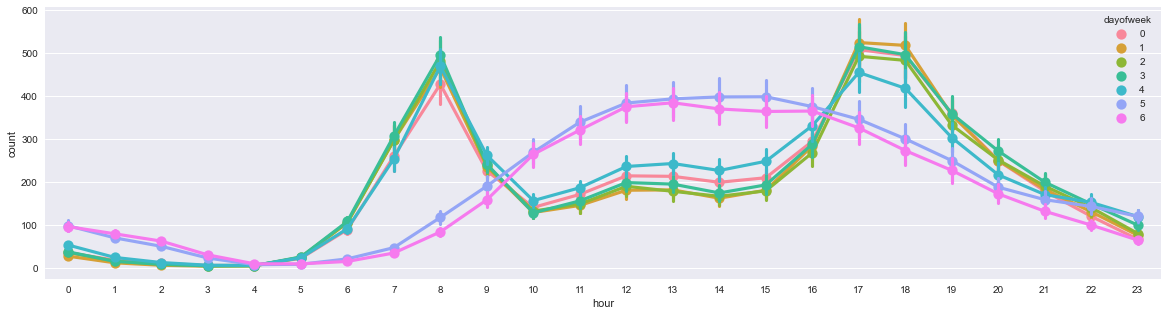

In [85]:
# 요일별도 찾아보자 
f, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.pointplot(data=df_train, x='hour', y='count', hue='dayofweek')

### 2) 수치형 데이터
- 상관관계를 사용해서 Heat map을 그려보고 scatter plot까지 그려봅니다

In [138]:
corr_data = df_train[['temp','atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']]

k = 11
cols = corr_data.corr().nlargest(k, 'count')['count'].index
print(cols)

Index(['count', 'registered', 'casual', 'temp', 'atemp', 'windspeed',
       'humidity'],
      dtype='object')


<AxesSubplot:title={'center':'Correlation of Numeric Features with Rental Count'}>

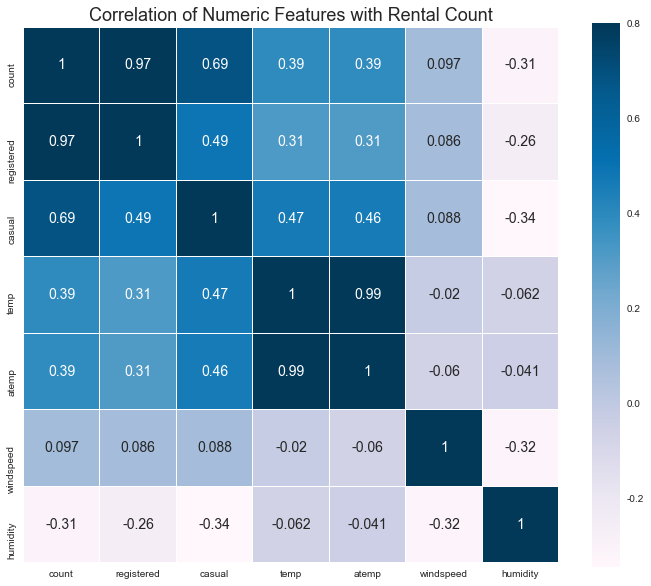

In [139]:
corr_data = df_train[['count', 'registered', 'casual', 'temp', 'atemp', 'windspeed','humidity']]

colormap = plt.cm.PuBu
f , ax = plt.subplots(figsize = (12,10)) 
plt.title('Correlation of Numeric Features with Rental Count',y=1,size=18) 
sns.heatmap(corr_data.corr(), vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap, 
            linecolor="white",annot_kws = {'size':14})

- temp랑 atemp는 거의 일치하는 변수  


- count와 가장 상관관계 높은 변수들 확인
    - registerd :  test데이터엔 존재하지 않음
    - casual
    - 이외에 temp, windspeed, huminity는 거의 관계가 없다고 봐도 무방  
    
count를 제외하고 5개의 변수들,

그 중 temp와 atemp 둘 중 하나만 남기고 없애면 4개.  그 중 관계있는 변수는 단 2개

<AxesSubplot:xlabel='humidity', ylabel='count'>

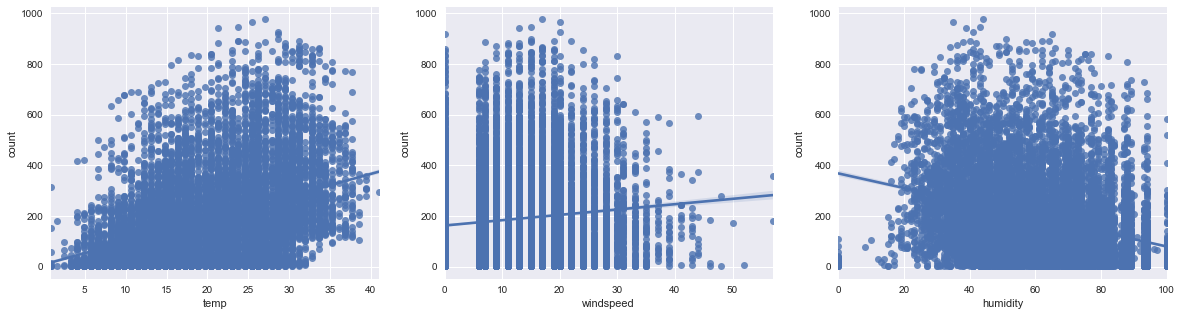

In [140]:
# 온도, 습도, 바람세기에 대해 알아보기
# 연속형 변수라서 scatter plot을 사용해 확인할 것임

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(20,5))

temp_scatter_plot = pd.concat([df_train['count'],df_train['temp']],axis = 1) 
sns.regplot(x='temp',y = 'count',data = temp_scatter_plot,scatter= True, fit_reg=True, ax=ax1) 

windspeed_scatter_plot = pd.concat([df_train['count'],df_train['windspeed']],axis = 1) 
sns.regplot(x='windspeed',y = 'count',data = windspeed_scatter_plot,scatter= True, fit_reg=True, ax=ax2) 

humidity_scatter_plot = pd.concat([df_train['count'],df_train['humidity']],axis = 1) 
sns.regplot(x='humidity',y = 'count',data = humidity_scatter_plot,scatter= True, fit_reg=True, ax=ax3)

# sns.scatterplot(data=train, x='temp', y='count',ax=ax1)
# sns.scatterplot(data=train, x='humidity', y='count',ax=ax2)
# sns.scatterplot(data=train, x='windspeed', y='count',ax=ax3)

# 풍속이 0인 경우가 흔치 않으므로 null 데이터를 모두 0 처리한 것이 아닐까?
# 왜냐면 결측치가 전체에서 하나도 없었음

In [141]:
# 바람세기 0인 자료들 몇개 인지 확인

len(df_train[df_train['windspeed']==0]) #1311개
# 0인 값을 대체하는 feature engineering을 수행하는 것

1311

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

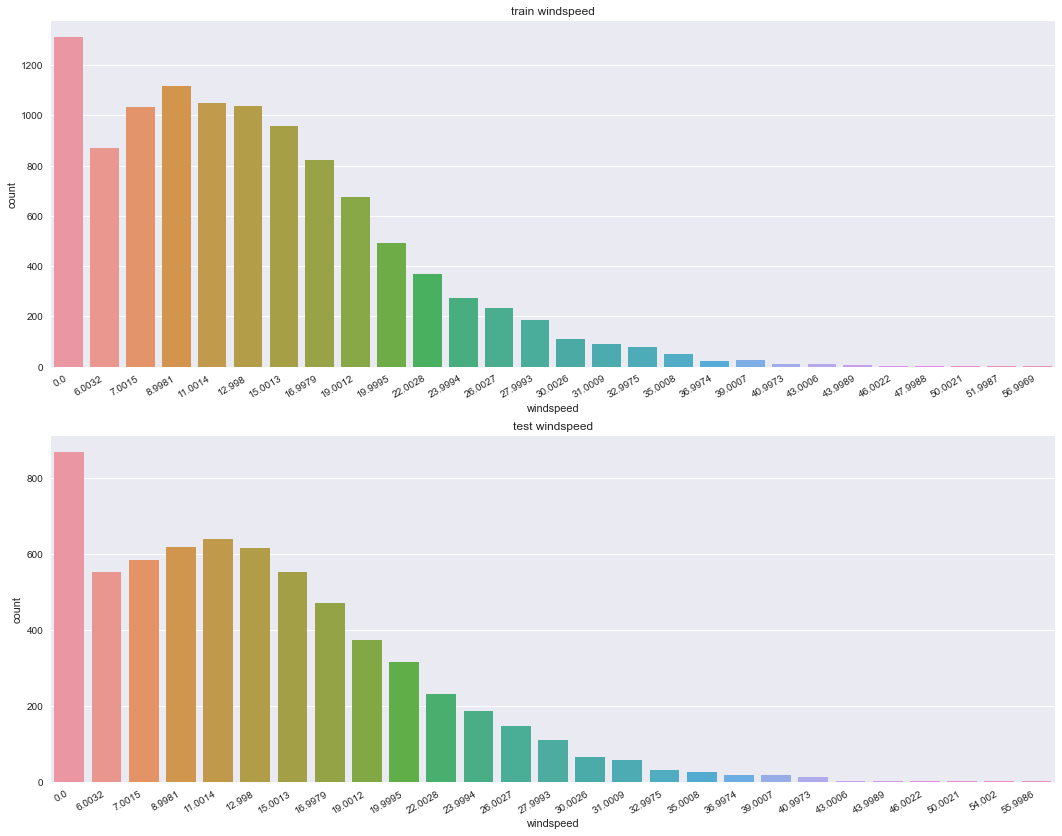

In [142]:
# scatter plot의 결과를 알아보기 위해 자세한 시각화 진행

fig, axes = plt.subplots(nrows = 2, figsize = (18,14)) 

# train 데이터에서도 확인
plt.sca(axes[0]) 
plt.xticks(rotation = 30, ha = "right") 
axes[0].set(ylabel = "count", title = "train windspeed") 
sns.countplot(data = df_train, x = "windspeed", ax = axes[0]) 

# test 데이터에서
plt.sca(axes[1]) 
plt.xticks(rotation = 30, ha = "right") 
axes[1].set(ylabel = "count", title = "test windspeed") 
sns.countplot(data = df_test, x = "windspeed", ax = axes[1])

# 이따가 고쳐줄게

In [143]:
# 연도별 데이터 확인을 위해 year와 month를 붙여줌

def concatenate_year_month(datetime): 
    return "{0}-{1}".format(datetime.year, datetime.month) 

df_train["year_month"] = df_train["datetime"].apply(concatenate_year_month) 
df_test["year_month"] = df_test["datetime"].apply(concatenate_year_month) 

print(df_train.shape) 
df_train[["datetime", "year_month"]].head()

(10846, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<AxesSubplot:xlabel='year_month', ylabel='count'>

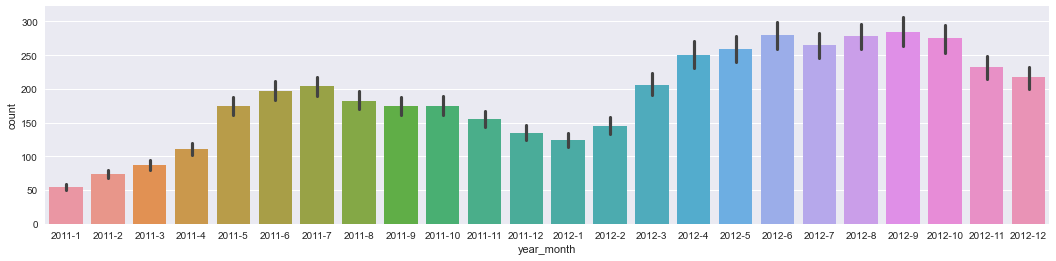

In [144]:
fig, ax = plt.subplots(figsize = (18,4)) 
sns.barplot(data = df_train, y = "count", x = "year_month")

# 12년도의 수요량이 더 높고, 따듯한 날씨에 가장 높음을 확인
# 증가하는 추세를 보임

In [145]:
df_train.shape

(10846, 20)

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental count by minute')]

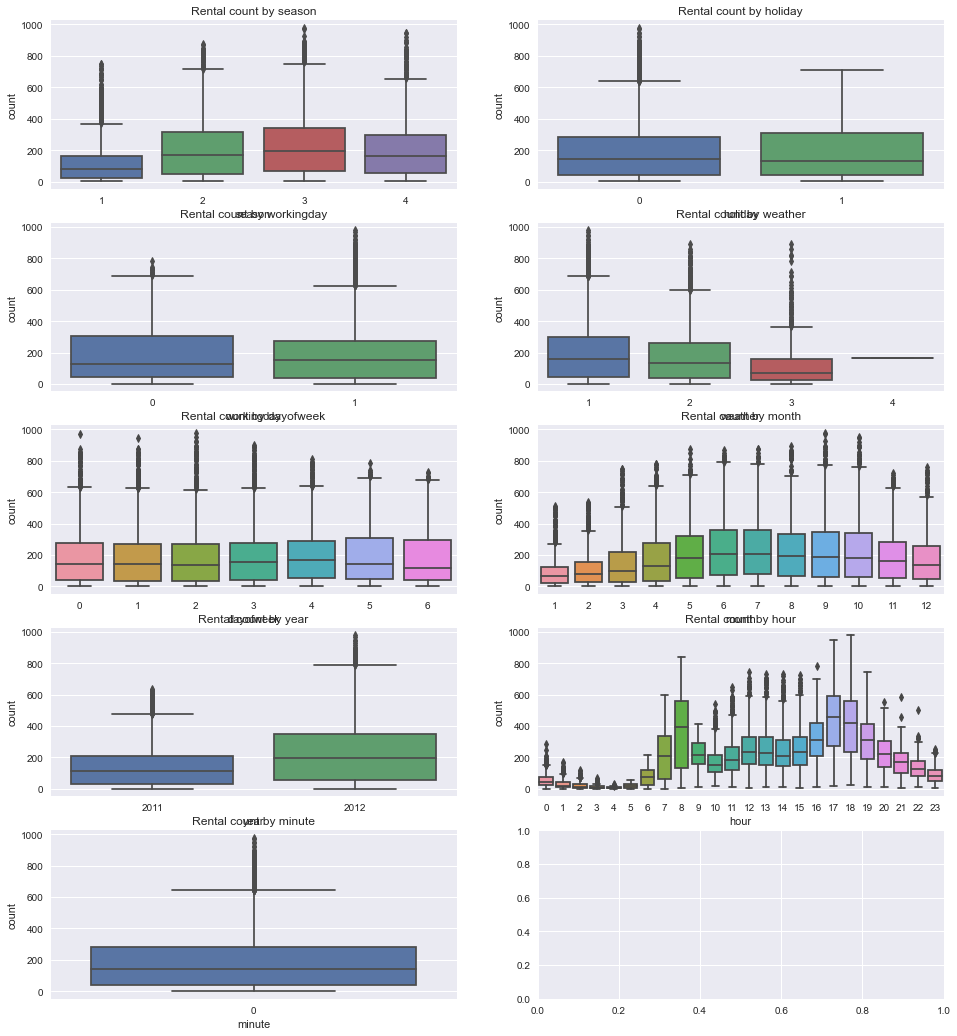

In [94]:
# boxplot그려보기

fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize=(16, 18)) 
sns.boxplot(data = df_train, y="count", x = "season", orient = "v", ax = axes[0][0]) 
sns.boxplot(data = df_train, y="count", x = "holiday", orient = "v", ax = axes[0][1]) 
sns.boxplot(data = df_train, y="count", x = "workingday", orient = "v", ax = axes[1][0]) 
sns.boxplot(data = df_train, y="count", x = "weather", orient = "v", ax = axes[1][1]) 
sns.boxplot(data = df_train, y="count", x = "dayofweek", orient = "v", ax = axes[2][0]) 
sns.boxplot(data = df_train, y="count", x = "month", orient = "v", ax = axes[2][1]) 
sns.boxplot(data = df_train, y="count", x = "year", orient = "v", ax = axes[3][0]) 
sns.boxplot(data = df_train, y="count", x = "hour", orient = "v", ax = axes[3][1]) 
sns.boxplot(data = df_train, y="count", x = "minute", orient = "v", ax = axes[4][0]) 

axes[0][0].set(ylabel = "count", title = "Rental count by season") 
axes[0][1].set(ylabel = "count", title = "Rental count by holiday") 
axes[1][0].set(ylabel = "count", title = "Rental count by workingday") 
axes[1][1].set(ylabel = "count", title = "Rental count by weather") 
axes[2][0].set(ylabel = "count", title = "Rental count by dayofweek") 
axes[2][1].set(ylabel = "count", title = "Rental count by month") 
axes[3][0].set(ylabel = "count", title = "Rental count by year") 
axes[3][1].set(ylabel = "count", title = "Rental count by hour") 
axes[4][0].set(ylabel = "count", title = "Rental count by minute")

## 3. Feature Engineering

- 비대칭성 처리
- 결측치 처리 (없네)
- 풍속 windspeed 처리 < 아까 하기로 했으니까
- 유의하지 않은 변수 삭제
- categorical 변수의 수치화


### 1) 비대칭성 처리

왜도
(-2 ~ +2)정도 되어야 치우침이 없는 데이터
- positive : square root, cube, log
- negative : square, cube root, logarithmic(밑2)

첨도
뾰족함에 집중하기 보다 tail에 대한 모든 것들 확인
첨도가 높다 = outlier가 많이 있다


Skewness: 1.210923
Kurtosis: 1.200871


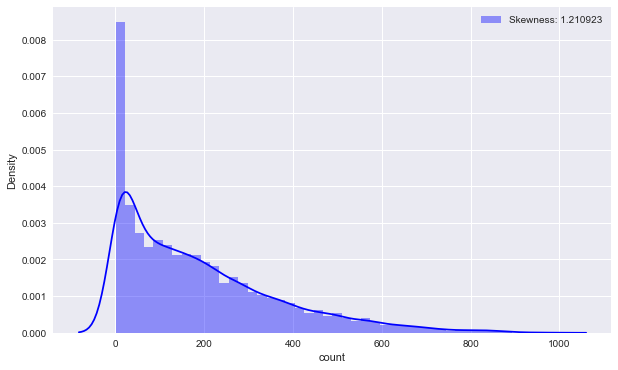

In [146]:
f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["count"], color = "b", label="Skewness: {:2f}".format(df_train["count"].skew()), ax=ax) 
g = g.legend(loc = "best") 
print("Skewness: %f" % df_train["count"].skew()) 
print("Kurtosis: %f" % df_train["count"].kurt())

# 수치적으로 크게 문제되지는 않지만 0에 너무 많이 몰려 있음


#### log scaling을 통한 정규화 작업

Skewness: -0.975198
Kurtosis: 0.247435


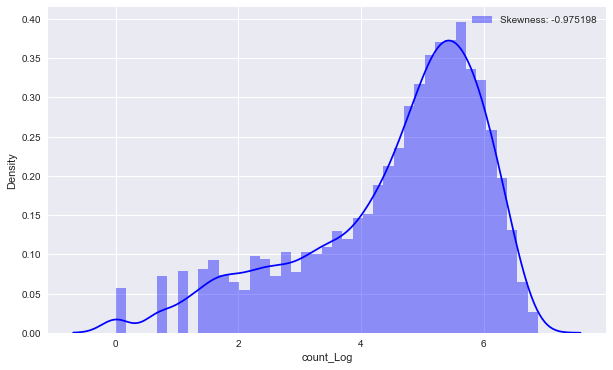

In [147]:
# 로그 변환
df_train["count_Log"] = df_train["count"].map(lambda i:np.log(i) if i>0 else 0) 

# 그림으로 확인해보자
f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["count_Log"], color = "b", 
                 label="Skewness: {:2f}".format(df_train["count_Log"].skew()), ax=ax) 
g = g.legend(loc = "best") 

# 수치도 알려줘
print("Skewness: %f" % df_train['count_Log'].skew()) 
print("Kurtosis: %f" % df_train['count_Log'].kurt()) 

# 기존 count 변수 삭제
df_train.drop('count', axis= 1, inplace=True)

In [163]:
# 분석에 사용되는 모든 변수들 모두 재확인하고 제거해줄게요

df_train_num = df_train[["count_Log","temp",'casual',"registered", "humidity", "windspeed"]] 
for col in df_train_num: 
    print('{:15}'.format(col), 'Skewness: {:05.2f}'.format(df_train[col].skew()) , ' ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt()) )

count_Log       Skewness: -0.98   Kurtosis: 000.25
temp            Skewness: 00.01   Kurtosis: -00.91
casual_Log      Skewness: -0.23   Kurtosis: -01.01
registered      Skewness: 01.51   Kurtosis: 002.61
humidity        Skewness: -0.09   Kurtosis: -00.76
windspeed       Skewness: 00.58   Kurtosis: 000.63


Skewness: 2.521368
Kurtosis: 7.735385


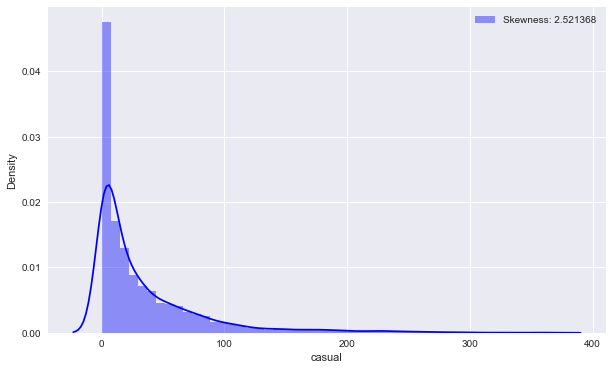

In [155]:
f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["casual"], color = "b", label="Skewness: {:2f}".format(df_train["casual"].skew()), ax=ax) 
g = g.legend(loc = "best") 
print("Skewness: %f" % df_train["casual"].skew()) 
print("Kurtosis: %f" % df_train["casual"].kurt())

Skewness: -0.227870
Kurtosis: -1.013562


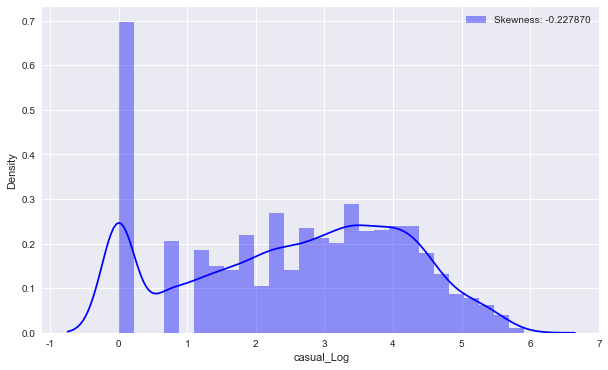

In [162]:
df_train["casual_Log"] = df_train["casual"].map(lambda i:np.log(i) if i>0 else 0) 

# 그림으로 확인해보자
f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["casual_Log"], color = "b", 
                 label="Skewness: {:2f}".format(df_train["casual_Log"].skew()), ax=ax) 
g = g.legend(loc = "best") 

# 수치도 알려줘
print("Skewness: %f" % df_train['casual_Log'].skew()) 
print("Kurtosis: %f" % df_train['casual_Log'].kurt()) 

# 기존 count 변수 삭제
df_train.drop('casual', axis= 1, inplace=True)

In [164]:
# 재확인
df_train_num = df_train[["count_Log","temp",'casual_Log',"registered", "humidity", "windspeed"]] 
for col in df_train_num: 
    print('{:15}'.format(col), 'Skewness: {:05.2f}'.format(df_train[col].skew()) , ' ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt()) )

count_Log       Skewness: -0.98   Kurtosis: 000.25
temp            Skewness: 00.01   Kurtosis: -00.91
casual_Log      Skewness: -0.23   Kurtosis: -01.01
registered      Skewness: 01.51   Kurtosis: 002.61
humidity        Skewness: -0.09   Kurtosis: -00.76
windspeed       Skewness: 00.58   Kurtosis: 000.63


### 2) windspeed 처리

풍속이 0일때는 거의 없기 때문에 windspeed 값을 대체해주기로 한다.

<<방법>>
- 결측값을 앞방향 혹은 뒷방향으로 채우가
- 결측값을 변수별 평균으로 채우기
- 결측값을 가진 데이터를 삭제하기
- 결측값을 0이나, 아예 다른 값으로 대체하기 
- 결측값을 예측된 값으로 대체 하기 (ML을 돌려서)

In [38]:
# windspeed 가 null값인 경우를 0으로 처리한 것이라고 생각했기에,
# 결측치를 채우는 방법중에 하나의 방법인 예측된 값으로 대체하는 방법을 사용

#### Random Forest를 활용해 windspeed = 0.0 값 대체하기 

In [166]:
from sklearn.ensemble import RandomForestClassifier 

def predict_windspeed(data): 
    dataWind0 = data.loc[data["windspeed"] == 0] 
    dataWindNot0 = data.loc[data["windspeed"] != 0] 
    
    wcol = ["season", "weather", "humidity", "day", "temp", "atemp"] 
    
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str") 
    
    rf_wind = RandomForestClassifier() 
    rf_wind.fit(dataWindNot0[wcol], dataWindNot0["windspeed"]) 
    wind0 = rf_wind.predict(X=dataWind0[wcol]) 
    
    predictWind0 = dataWind0 
    predictWindNot0 = dataWindNot0 
    
    predictWind0["windspeed"] = wind0 
    
    data = predictWindNot0.append(predictWind0) 
    
    data["windspeed"] = data["windspeed"].astype("float") 
    
    data.reset_index(inplace = True) 
    data.drop("index", inplace = True, axis = 1) 
    
    return data


In [167]:
df_train = predict_windspeed(df_train) 
df_test = predict_windspeed(df_test) 

<AxesSubplot:xlabel='windspeed', ylabel='count'>

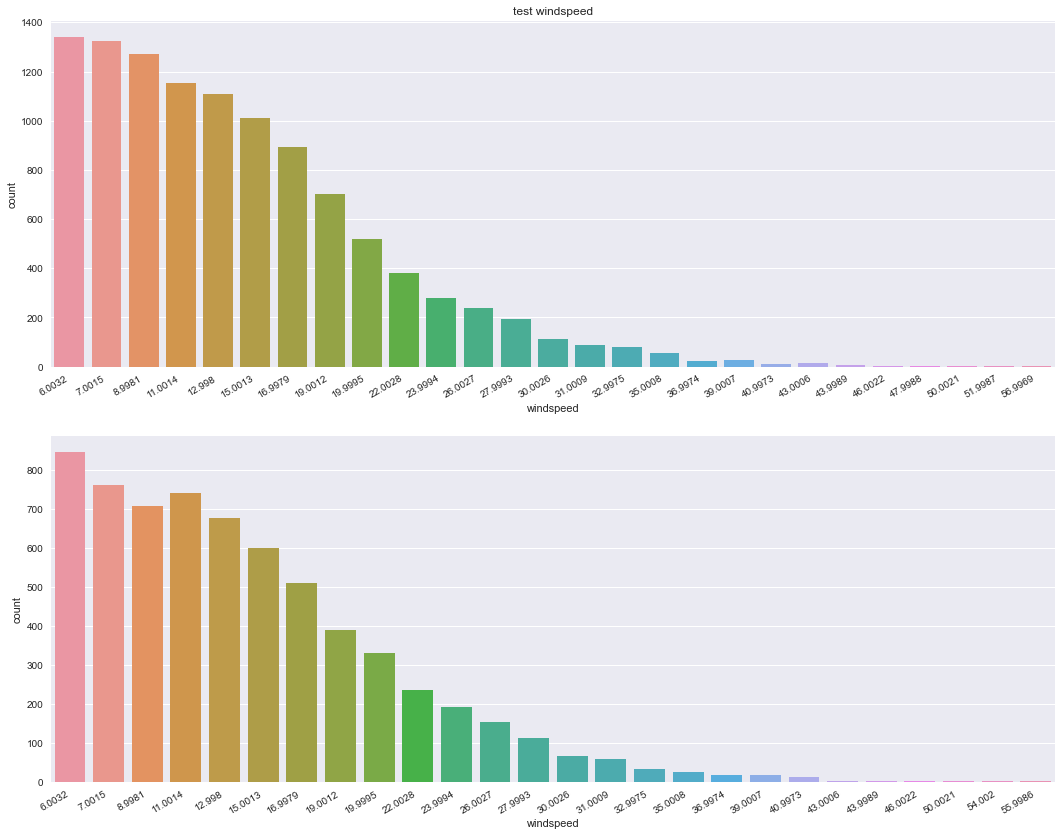

In [168]:
# 확인해보자

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (18,14)) 
plt.sca(ax1) 
plt.xticks(rotation = 30, ha = "right") 
ax1.set(ylabel = "count", title = "train windspeed") 
sns.countplot(data = df_train, x = "windspeed", ax = ax1) 

plt.sca(ax2) 
plt.xticks(rotation = 30, ha = "right") 
ax1.set(ylabel = "count", title = "test windspeed") 
sns.countplot(data = df_test, x = "windspeed", ax = ax2)

In [169]:
df_train[df_train['windspeed']==0.0]
# 없음을 확인~~

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,year,month,day,hour,minute,second,dayofweek,year_month,count_Log,casual_Log


In [170]:
corr_data = df_train[["count_Log", "windspeed"]] 
corr_data.corr()

,count_Log,windspeed
count_Log,1.000000,0.124068
windspeed,0.124068,1.000000


### 3) categorical feature 변형

In [171]:
# one-hot encoding 으로 변경

df_train = pd.get_dummies(df_train, columns = ["weather"], prefix = "weather") 
df_test = pd.get_dummies(df_test, columns = ["weather"], prefix = "weather") 

df_train = pd.get_dummies(df_train, columns = ["season"], prefix = "season") 
df_test = pd.get_dummies(df_test, columns = ["season"], prefix = "season")

In [172]:
df_train.head() # 잘 들어갔음을 확인

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,registered,year,month,...,count_Log,casual_Log,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,2011-01-01 05:00:00,0,0,9.84,12.880,75,6.0032,1,2011,1,...,0.000000,0.000000,0,1,0,0,1,0,0,0
1,2011-01-01 10:00:00,0,0,15.58,19.695,76,16.9979,24,2011,1,...,3.583519,2.484907,1,0,0,0,1,0,0,0
2,2011-01-01 11:00:00,0,0,14.76,16.665,81,19.0012,30,2011,1,...,4.025352,3.258097,1,0,0,0,1,0,0,0
3,2011-01-01 12:00:00,0,0,17.22,21.210,77,19.0012,55,2011,1,...,4.430817,3.367296,1,0,0,0,1,0,0,0
4,2011-01-01 13:00:00,0,0,18.86,22.725,72,19.9995,47,2011,1,...,4.543295,3.850148,0,1,0,0,1,0,0,0


성능을 높이기 위해 만들수 있는 파생변수는 여러가지가 있다.  
특히 날씨에 관한 변수같은 경우에는 여러가지 수식을 활용하면 다양한 검증된 변수를 사용할 수 있음.  

해보세요

In [ ]:
# 요일도 categorical만들어볼까

### 4) 유의하지 않은 변수 삭제
- 학습에 사용할 train 셋과 test셋을 정리

In [174]:
datetime_test = df_test['datetime'] 

# 파생변수들 삭제
df_train.drop(["datetime", "registered","casual_Log","holiday", "year_month", "minute", "second"], axis = 1, inplace = True) 
df_test.drop(["datetime","holiday", "year_month", "minute", "second"], axis = 1, inplace = True)

In [175]:
df_train.shape, df_test.shape

((10846, 19), (6493, 18))

In [177]:
df_train.columns, df_test.columns

(Index(['workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month',
        'day', 'hour', 'dayofweek', 'count_Log', 'weather_1', 'weather_2',
        'weather_3', 'weather_4', 'season_1', 'season_2', 'season_3',
        'season_4'],
       dtype='object'),
 Index(['workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month',
        'day', 'hour', 'dayofweek', 'weather_1', 'weather_2', 'weather_3',
        'weather_4', 'season_1', 'season_2', 'season_3', 'season_4'],
       dtype='object'))

## 4. Modeling & make submission

In [189]:
# 데이터 셋 분할
from sklearn.model_selection import train_test_split
from sklearn import metrics

# array여야 하기 때문에 꼭 변경 해야됨~~~!!!
X_train = df_train.drop('count_Log', axis=1).values
target_label = df_train['count_Log'].values
X_test = df_test.values

# train : val = 0.8 : 0.2 로 split
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, random_state = 2000)

In [190]:
X_val

array([[ 1.   , 20.5  , 24.24 , ...,  0.   ,  0.   ,  1.   ],
       [ 1.   , 30.34 , 33.335, ...,  0.   ,  1.   ,  0.   ],
       [ 0.   , 12.3  , 15.91 , ...,  0.   ,  0.   ,  1.   ],
       ...,
       [ 1.   , 13.12 , 15.91 , ...,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  9.84 , 14.395, ...,  0.   ,  0.   ,  1.   ],
       [ 1.   , 26.24 , 28.79 , ...,  0.   ,  1.   ,  0.   ]])

### 모델링 학습

GradientBoosting 모델

In [191]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(n_estimators=2000, learning_rate = 0.05,
                                      max_depth=4, min_samples_leaf=15,
                                      min_samples_split=10, random_state=42)
regressor.fit(X_tr, y_tr)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=15,
                          min_samples_split=10, n_estimators=2000,
                          random_state=42)

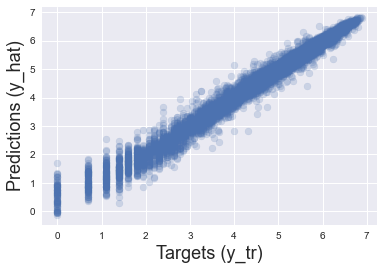

0.978480883529766


In [202]:
y_hat = regressor.predict(X_tr)

plt.scatter(y_tr, y_hat, alpha=0.2)
plt.xlabel("Targets (y_tr)", size = 18)
plt.ylabel("Predictions (y_hat)", size=18)
plt.show()
print(regressor.score(X_tr,y_tr))
# 학습용 데이터셋에 얼마나 잘 적합됐는지 확인

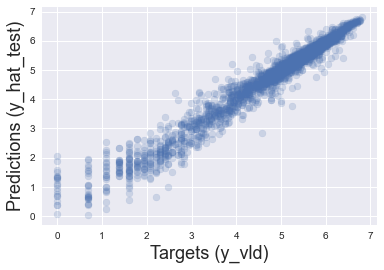

0.9537988515663921


In [203]:
y_hat_test = regressor.predict(X_vld)

plt.scatter(y_vld, y_hat_test, alpha=0.2)
plt.xlabel("Targets (y_vld)", size = 18)
plt.ylabel("Predictions (y_hat_test)", size=18)
plt.show()
# 검증용 데이터 셋도 확인

print(regressor.score(X_vld, y_vld))

In [195]:
# print(accuracies.mean()) 
# print(accuracies.std())
# 정확도 확인

### 예측 및 submission 생성

예측.
앞서 만든 regressor 모델에 x_test를 넣어 예측을 수행한 후 
submisson의 형태에 맞게 저장

In [200]:
# 로그 적용 전으로

use_logvals = 1

pred_gb = regressor.predict(X_test)

sub_gb = pd.DataFrame()
sub_gb['datetime'] = datetime_test
sub_gb['count'] = pred_gb
if use_logvals == 1:
    sub_gb['count'] = np.exp(sub_gb['count'])

## 최종 제출

In [201]:
sub_gb.to_csv("./submission/Bike.csv", index = False)